**Data Preparation**

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import numpy as np

#KMNIST dataset
kmnist_data, kmnist_info = tfds.load('kmnist', split=['train', 'test'], as_supervised=True, with_info=True)

# Preprocessing the data
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [28, 28])
    return image, label

# Applying preprocessing to the training and test datasets
train_data = kmnist_data[0].map(preprocess_image)
test_data = kmnist_data[1].map(preprocess_image)

# Preparing training data
x_train, y_train = [], []
for img, label in train_data:
    x_train.append(img.numpy().flatten())
    y_train.append(label.numpy())

x_train = np.array(x_train)
y_train = np.array(y_train)

# Splitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Preparing test data
x_test, y_test = [], []
for img, label in test_data:
    x_test.append(img.numpy().flatten())
    y_test.append(label.numpy())

x_test = np.array(x_test)
y_test = np.array(y_test)

print(f'Training data shape: {x_train.shape}, Validation data shape: {x_val.shape}, Test data shape: {x_test.shape}')


Training data shape: (48000, 784), Validation data shape: (12000, 784), Test data shape: (10000, 784)


**Radial Basis Function (RBF) Network**

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

class RBF(tf.keras.Model):
    def __init__(self, num_hidden_units):
        super(RBF, self).__init__()
        self.num_hidden_units = num_hidden_units
        self.centers = tf.Variable(tf.random.uniform((num_hidden_units, 784), 0, 1))
        self.bias = tf.Variable(tf.zeros(num_hidden_units))
        self.output_layer = layers.Dense(10, activation='softmax')

    def call(self, x):
        distance = tf.norm(tf.expand_dims(x, axis=1) - self.centers, axis=2)
        rbf_output = tf.exp(-tf.square(distance))
        return self.output_layer(rbf_output + self.bias)

num_hidden_units = 64
model = RBF(num_hidden_units)


**Training**

In [15]:
from sklearn.cluster import KMeans

#K-means to find centers
kmeans = KMeans(n_clusters=num_hidden_units, random_state=42)
kmeans.fit(x_train)
model.centers.assign(kmeans.cluster_centers_)


<tf.Variable 'UnreadVariable' shape=(64, 784) dtype=float32, numpy=
array([[6.17648300e-04, 1.40196760e-03, 8.03930685e-04, ...,
        4.15686565e-03, 1.27460342e-04, 5.82076609e-09],
       [8.38190317e-09, 3.75050120e-04, 1.08724297e-03, ...,
        7.87988305e-04, 4.79559880e-04, 1.99393253e-04],
       [1.15207734e-03, 1.24242867e-03, 1.14757824e-03, ...,
        3.04045249e-03, 2.19123019e-03, 2.09632097e-03],
       ...,
       [4.99999907e-04, 2.53921631e-03, 6.05882332e-03, ...,
        5.16666938e-03, 1.92155363e-03, 6.86321873e-05],
       [1.65940262e-03, 2.05652090e-03, 1.47504290e-03, ...,
        4.72290441e-03, 2.28345767e-03, 5.31865400e-04],
       [6.75208867e-09, 7.27474689e-05, 7.56683294e-04, ...,
        9.38490964e-04, 1.17866416e-03, 1.16416835e-04]], dtype=float32)>

In [16]:
#loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 100
batch_size = 64

for epoch in range(epochs):
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)

    for i in range(0, len(x_train), batch_size):
        batch_indices = indices[i:i + batch_size]
        with tf.GradientTape() as tape:
            predictions = model(x_train[batch_indices])
            loss = loss_fn(y_train[batch_indices], predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}')


Epoch 1/100, Loss: 2.305028200149536
Epoch 2/100, Loss: 2.306403160095215
Epoch 3/100, Loss: 2.2930941581726074
Epoch 4/100, Loss: 2.2994189262390137
Epoch 5/100, Loss: 2.3085498809814453
Epoch 6/100, Loss: 2.3034515380859375
Epoch 7/100, Loss: 2.305459499359131
Epoch 8/100, Loss: 2.3018746376037598
Epoch 9/100, Loss: 2.302731513977051
Epoch 10/100, Loss: 2.301572799682617
Epoch 11/100, Loss: 2.3045997619628906
Epoch 12/100, Loss: 2.298118829727173
Epoch 13/100, Loss: 2.301370143890381
Epoch 14/100, Loss: 2.3014252185821533
Epoch 15/100, Loss: 2.301734685897827
Epoch 16/100, Loss: 2.3037033081054688
Epoch 17/100, Loss: 2.315609931945801
Epoch 18/100, Loss: 2.301865339279175
Epoch 19/100, Loss: 2.311182975769043
Epoch 20/100, Loss: 2.2949109077453613
Epoch 21/100, Loss: 2.3115458488464355
Epoch 22/100, Loss: 2.3113231658935547
Epoch 23/100, Loss: 2.303136110305786
Epoch 24/100, Loss: 2.3034801483154297
Epoch 25/100, Loss: 2.300459623336792
Epoch 26/100, Loss: 2.299020767211914
Epoch 27/

**Evaluation**

Test Accuracy: 10.00%


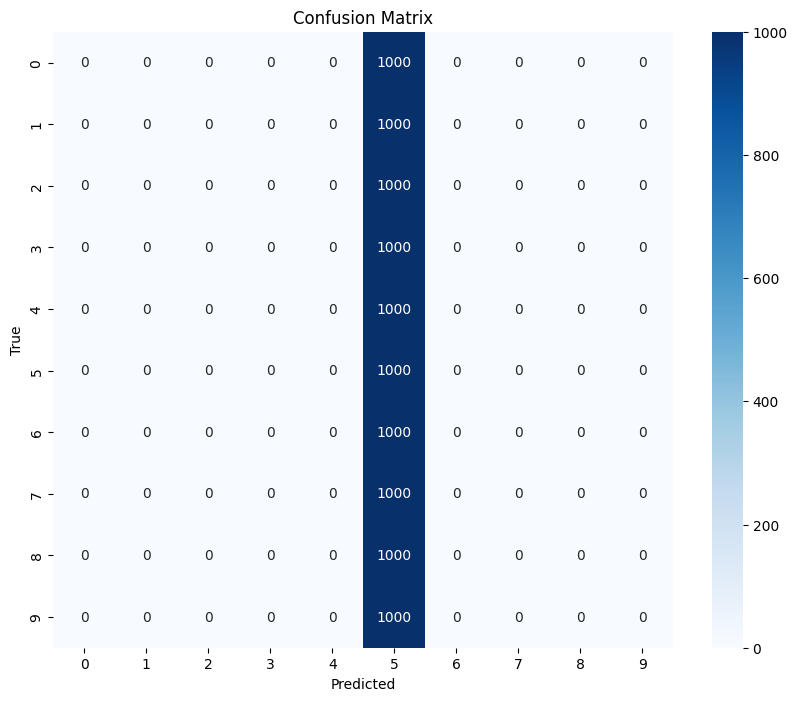

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

#predictions for test set
y_pred = model(x_test).numpy().argmax(axis=1)

#accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

#confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Analysis**

**Discuss the strengths and limitations of using an RBF network for this
dataset.**



**Strengths of Using an RBF Network**

Good for Non-linear Problems:

* RBF networks are particularly effective for problems where the decision boundary is non-linear. The Gaussian basis functions allow the model to adapt to complex patterns in the data, making them suitable for character recognition tasks like classifying ancient Japanese characters.

Locality:

* The RBF function has a localized response to inputs, meaning that it can effectively model complex local structures in the input space. This is beneficial in image classification, where specific features (like strokes or shapes) are important.

Robustness to Overfitting:

* With proper regularization and tuning of the number of RBF units, these networks can avoid overfitting, especially in cases where the training dataset is small relative to the input dimension (as is often the case with image data).

Fast Training:

* Once the centers of the RBF units are determined (using techniques like K-means), the training process is relatively fast since it primarily involves updating the weights, making it computationally efficient.

Interpretability:

* The structure of RBF networks allows for some interpretability. The influence of each RBF unit can be traced back to specific areas in the input space, helping to understand which features contribute most to the classifications.

**Limitations of Using an RBF Network**

Choice of Centers:

The performance of an RBF network heavily relies on the selection of RBF centers. If the centers are not well chosen, the model may fail to capture the underlying data distribution effectively.

Sensitivity to Parameters:

* The model's performance can be sensitive to the width parameter of the Gaussian functions. If the width is too small, the RBF units may respond too narrowly, leading to overfitting.

Scalability:

* As the dataset size increases, RBF networks can become computationally expensive. The K-means clustering step and the calculations for Gaussian activations can be slow with large datasets, especially when the input dimensionality is high.

Limited Generalization:

* RBF networks can struggle to generalize well beyond the training set if not carefully tuned. They may not perform as well on unseen data compared to other neural network architectures, like convolutional neural networks, which are often preferred for image data.

Not Widely Used in Practice:

* While RBF networks are theoretically interesting, they are less commonly used in practical applications compared to deep learning approaches. As a result, there may be fewer resources and community support for troubleshooting and optimization.

**How does the number of RBF units affect model performance?**

Underfitting vs. Overfitting:

* Few RBF Units: If the number of RBF units is too low, the network may not have enough capacity to capture the complexity of the data. This can lead to underfitting, where the model fails to learn the underlying patterns, resulting in poor performance on both training and test datasets.

* Too Many RBF Units: Conversely, if the number of RBF units is excessively high, the model may become overly complex, capturing noise in the training data. This can lead to overfitting, where the model performs well on training data but poorly on unseen data, resulting in a decrease in generalization ability.

Computational Complexity:

* The computational complexity of the model increases with the number of RBF units. Training and inference times may rise, which can be a limitation for real-time applications or when working with large datasets.

Performance Tuning:

* Finding the optimal number of RBF units is crucial. Typically, this is done through cross-validation, where different configurations are tested to see which provides the best trade-off between bias and variance. The optimal number may vary based on the dataset characteristics, such as complexity and size.

Influence on Decision Boundaries:

* The decision boundaries of the RBF network are influenced by the positions of the RBF centers and the number of units. More units can lead to more complex decision boundaries, which can be beneficial for datasets with intricate class distributions.